In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime as dt
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import normaltest

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
colors = sns.color_palette('deep', 8)
sns.set_palette(colors)

# Ethereum Time Series Analysis, ARIMA Forecasting

## Contents
1. [Load & Visualize Time Series](#load_viz)
2. [Structural Breaks & Change Point Detection](#cpd)
3. [Autocorrelation Functions (ACF/PACF)](#acf_pacf)
4. [Granger Causality](#granger_causality)
5. [Forecasting](#fc), [Forecasting with exogenous shift](#fc_shift)

<a id='load_viz'></a>
## Load & Visualize Time Series

In [2]:
df_orig = pd.read_json('../datasets/df.json', orient='split')
print(df_orig.info())
df_orig.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2981 entries, 0 to 2980
Data columns (total 16 columns):
date              2981 non-null datetime64[ns]
eth_open          1134 non-null float64
eth_high          1134 non-null float64
eth_low           1134 non-null float64
eth_close         1134 non-null float64
eth_volumefrom    1134 non-null float64
eth_volumeto      1134 non-null float64
btc               2981 non-null float64
xrp               1332 non-null float64
eos               442 non-null float64
ltc               1786 non-null float64
xlm               605 non-null float64
xmr               1324 non-null float64
vixcls            2981 non-null float64
twexb             2981 non-null float64
effr              2981 non-null float64
dtypes: datetime64[ns](1), float64(15)
memory usage: 395.9 KB
None


,date,eth_open,eth_high,eth_low,eth_close,eth_volumefrom,eth_volumeto,btc,xrp,eos,ltc,xlm,xmr,vixcls,twexb,effr
0,2010-07-16,NaN,NaN,NaN,NaN,NaN,NaN,0.04951,NaN,NaN,NaN,NaN,NaN,26.25,103.1938,0.19
1,2010-07-17,NaN,NaN,NaN,NaN,NaN,NaN,0.08584,NaN,NaN,NaN,NaN,NaN,26.25,103.1938,0.19
2,2010-07-18,NaN,NaN,NaN,NaN,NaN,NaN,0.08080,NaN,NaN,NaN,NaN,NaN,26.25,103.1938,0.19


In [3]:
# set df for time series
df = df_orig.copy()

# start at beginning of ethereum
df = df[df.eth_close.isnull().sum():]
df.set_index('date', inplace=True)
df.head(3)

,eth_open,eth_high,eth_low,eth_close,eth_volumefrom,eth_volumeto,btc,xrp,eos,ltc,xlm,xmr,vixcls,twexb,effr
date,,,,,,,,,,,,,,,
2015-08-06,0.6747,3.0,0.6747,3.0,123.93,371.79,277.89,0.008013,NaN,4.10,NaN,0.75,13.77,118.1833,0.14
2015-08-07,3.0000,3.0,0.1500,1.2,2119.43,1438.16,258.60,0.009000,NaN,3.77,NaN,0.75,13.39,118.1833,0.14
2015-08-08,1.2000,1.2,1.2000,1.2,0.00,0.00,263.87,0.008700,NaN,3.87,NaN,0.75,13.39,118.1833,0.14


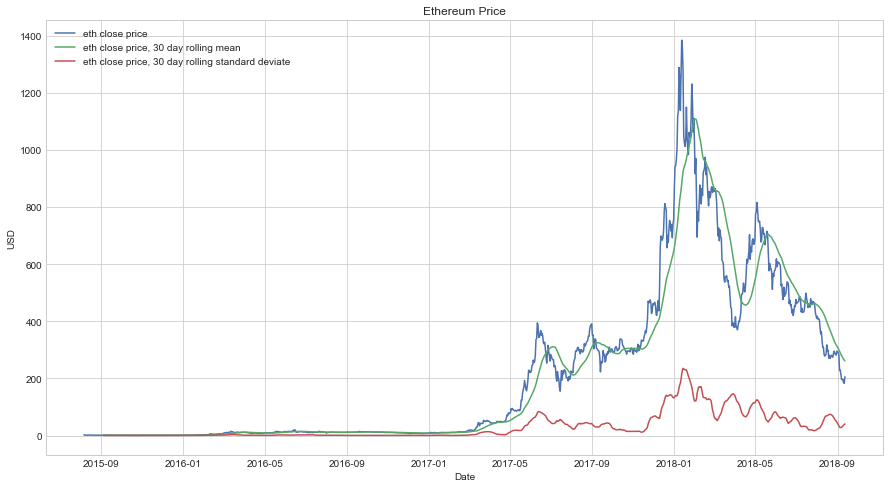

adf: -1.8088972361212996
pval: 0.37605349542421385
critical vals {'1%': -3.4362549432361504, '5%': -2.8641473395601595, '10%': -2.568158225793361}


In [4]:
plt.figure(figsize=(15,8))
plt.plot(
    df.index.values,
    df.eth_close,
    label='eth close price',
    color=colors[0]
)
plt.plot(
    df.index.values,
    df.eth_close.rolling(30).mean(),
    label='eth close price, 30 day rolling mean',
    color=colors[1]
)
plt.plot(
    df.index.values,
    df.eth_close.rolling(30).std(),
    label='eth close price, 30 day rolling standard deviate',
    color=colors[2]
)
plt.title('Ethereum Price')
plt.ylabel('USD')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.show()

from statsmodels.tsa.stattools import adfuller
print('adf: {0}\npval: {1}\ncritical vals {2}'.format(
    adfuller(df.eth_close)[0],
    adfuller(df.eth_close)[1],
    adfuller(df.eth_close)[4]))

**Interpretation:**
- Data displays trend(s), ADF test confirms non-stationarity
    - Employ techniques to achieve stationarity
- Data does not appear to have a seasonality component
- Graph indicates presence of structural breaks
    - Perform change point analysis

<a id='cpd'></a>
## Structural Breaks & Change Point Detection
- [Ruptures Library](https://github.com/deepcharles/ruptures) used for change point detection
- Pruned Exact Linear Time (PELT): penalized change point detection algorithm

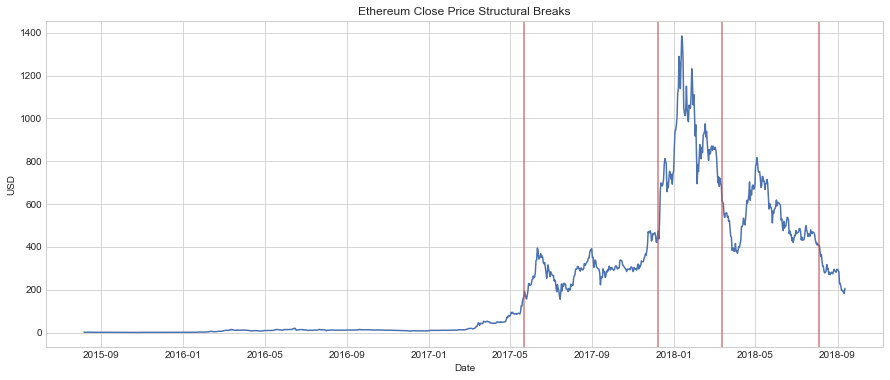

Change points by index: [655, 855, 950, 1095]


In [5]:
import ruptures as rpt
cpts = rpt.Pelt(model='rbf').fit_predict(pd.DataFrame(df.eth_close), pen=20)

fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Ethereum Close Price Structural Breaks')
ax.plot(
    df.index.values,
    df.eth_close,
    #label='eth close price',
    color=colors[0]
)
for cpt in cpts[:-1]:
    plt.axvline(
        x=df.index.values[cpt],
        color=colors[2],
        alpha=.75
    )
ax.set_ylabel('USD')
ax.set_xlabel('Date')

plt.show()

print('Change points by index: {}'.format(cpts[:-1]))

In [6]:
# create dummies for breaks
points = cpts[:-1]

for point in points:
    df['cpt_{}'.format(point)] = 0
    
#df.cpt_0[:655] = 1
df.cpt_655[655:] = 1
df.cpt_855[855:] = 1
df.cpt_950[950:] = 1
df.cpt_1095[1095:] = 1

In [7]:
df.head(3)

,eth_open,eth_high,eth_low,eth_close,eth_volumefrom,eth_volumeto,btc,xrp,eos,ltc,xlm,xmr,vixcls,twexb,effr,cpt_655,cpt_855,cpt_950,cpt_1095
date,,,,,,,,,,,,,,,,,,,
2015-08-06,0.6747,3.0,0.6747,3.0,123.93,371.79,277.89,0.008013,NaN,4.10,NaN,0.75,13.77,118.1833,0.14,0,0,0,0
2015-08-07,3.0000,3.0,0.1500,1.2,2119.43,1438.16,258.60,0.009000,NaN,3.77,NaN,0.75,13.39,118.1833,0.14,0,0,0,0
2015-08-08,1.2000,1.2,1.2000,1.2,0.00,0.00,263.87,0.008700,NaN,3.87,NaN,0.75,13.39,118.1833,0.14,0,0,0,0


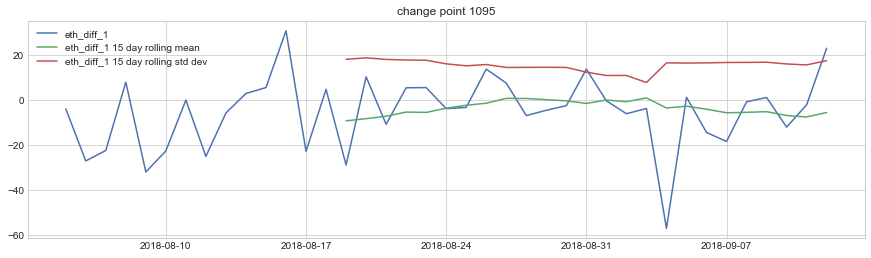


diff_1 adf results:
adf -6.3110
pval 3.235505524566548e-08
critical vals {'1%': -3.6155091011809297, '5%': -2.941262357486514, '10%': -2.6091995013850418}


In [8]:
# stationarity
df['eth_diff_1'] = sm.tsa.statespace.tools.diff(df.eth_close, k_diff=1)

fig, ax = plt.subplots(figsize=(15,4))
ax.set_title('change point {}'.format(cpts[3]))
ax.plot(df.index.values[cpts[3]:],
        df.eth_diff_1[cpts[3]:],
        label='eth_diff_1')
ax.plot(df.index.values[cpts[3]:],
        df.eth_diff_1[cpts[3]:].rolling(15).mean(),
        label='eth_diff_1 15 day rolling mean')
ax.plot(df.index.values[cpts[3]:],
        df.eth_diff_1[cpts[3]:].rolling(15).std(),
        label='eth_diff_1 15 day rolling std dev')
plt.legend()
plt.show()

print('\ndiff_1 adf results:\nadf {:.4f}\npval {}\ncritical vals {}'.format(
    adfuller(df.eth_diff_1[cpts[3]:])[0],
    adfuller(df.eth_diff_1[cpts[3]:])[1],
    adfuller(df.eth_diff_1[cpts[3]:])[4]))

<a id='acf_pacf'></a>
## Autocorrelation Functions (ACF/PACF)

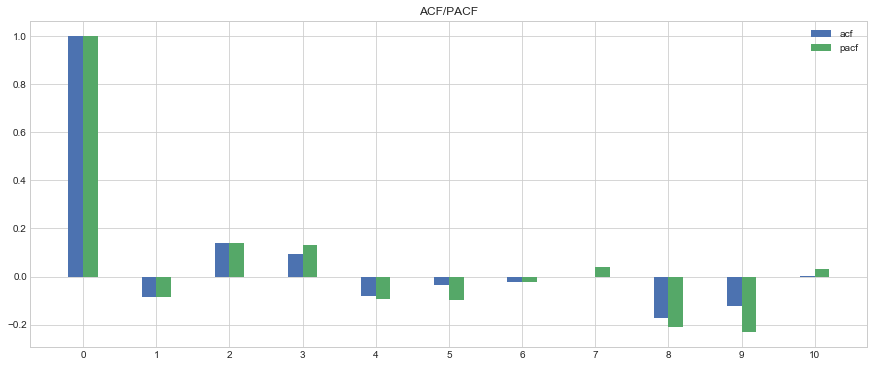

In [9]:
diff_1_acf = acf(df.eth_diff_1[cpts[3]:], nlags=10)
diff_1_pacf = pacf(df.eth_diff_1[cpts[3]:], nlags=10)

fig, ax = plt.subplots(figsize=(15,6))
ax.bar(
    [n-.1 for n in range(len(diff_1_acf))],
    diff_1_acf,
    label='acf',
    width=.2,
    color=colors[0],
    align='center'
)
ax.bar(
    [n+.1 for n in range(len(diff_1_acf))],
    diff_1_pacf,
    label='pacf',
    width=.2,
    color=colors[1],
    align='center'
)
ax.legend()
ax.set(title='ACF/PACF',
       xticks= [n for n in range(len(diff_1_acf))])

plt.show()

**Interpretation**: No AR or MA component

<a id='granger_causality'></a>
## Granger Causality

In [10]:
from statsmodels.tsa.stattools import grangercausalitytests

cols = list(
    df[cpts[3]:].loc[:, ~(df[cpts[3]:].columns).isin(['eth_close',
                                                'cpt_0',
                                                'cpt_655',
                                                'cpt_855',
                                                'cpt_950',
                                                'cpt_1095'])].columns
)

print('endog eth_close')
for col in cols:
    results = grangercausalitytests(df[cpts[3]:][['eth_close', '{}'.format(col)]],
                                    maxlag=1,
                                    verbose=False)
    print('{}\nexog {} on endog'.format('-'*79, col))
    
    for key, value in results.items():
        if value[0]['ssr_ftest'][1] <= 0.05:
            print('ssr_ftest: f statistic: {:.5f}, p-value: {:.5f}'.format(
                value[0]['ssr_ftest'][0], value[0]['ssr_ftest'][1]))   
            
        if value[0]['ssr_chi2test'][1] <= 0.05:
            print('ssr_chi2test: f statistic: {:.5f}, p-value: {:.5f}'.format(
                value[0]['ssr_chi2test'][0], value[0]['ssr_chi2test'][1]))
       
        if value[0]['lrtest'][1] <= 0.05:
            print('lrtest: f statistic: {:.5f}, p-value: {:.5f}'.format(
                value[0]['lrtest'][0], value[0]['lrtest'][1]))
        
        if value[0]['params_ftest'][1] <= 0.05:
            print('params_ftest: f statistic: {:.5f}, p-value: {:.5f}'.format(
                value[0]['params_ftest'][0], value[0]['params_ftest'][1]))        
        
        else:
            print('no significant p-values')
    
    results_ = grangercausalitytests(df[cpts[3]:][['{}'.format(col), 'eth_close']],
                                    maxlag=1,
                                    verbose=False)
    print('\nendog on exog {}'.format(col))
    
    for key, value in results_.items():
        if value[0]['ssr_ftest'][1] <= 0.05:
            print('ssr_ftest: f statistic: {:.5f}, p-value: {:.5f}'.format(
                value[0]['ssr_ftest'][0], value[0]['ssr_ftest'][1]))   
            
        if value[0]['ssr_chi2test'][1] <= 0.05:
            print('ssr_chi2test: f statistic: {:.5f}, p-value: {:.5f}'.format(
                value[0]['ssr_chi2test'][0], value[0]['ssr_chi2test'][1]))
       
        if value[0]['lrtest'][1] <= 0.05:
            print('lrtest: f statistic: {:.5f}, p-value: {:.5f}'.format(
                value[0]['lrtest'][0], value[0]['lrtest'][1]))
        
        if value[0]['params_ftest'][1] <= 0.05:
            print('params_ftest: f statistic: {:.5f}, p-value: {:.5f}'.format(
                value[0]['params_ftest'][0], value[0]['params_ftest'][1]))        
        
        else:
            print('no significant p-values')

endog eth_close
-------------------------------------------------------------------------------
exog eth_open on endog
no significant p-values

endog on exog eth_open
ssr_ftest: f statistic: 3985.30162, p-value: 0.00000
ssr_chi2test: f statistic: 4326.89890, p-value: 0.00000
lrtest: f statistic: 180.26304, p-value: 0.00000
params_ftest: f statistic: 3985.30162, p-value: 0.00000
-------------------------------------------------------------------------------
exog eth_high on endog
no significant p-values

endog on exog eth_high
ssr_ftest: f statistic: 91.92956, p-value: 0.00000
ssr_chi2test: f statistic: 99.80923, p-value: 0.00000
lrtest: f statistic: 48.95480, p-value: 0.00000
params_ftest: f statistic: 91.92956, p-value: 0.00000
-------------------------------------------------------------------------------
exog eth_low on endog
no significant p-values

endog on exog eth_low
ssr_ftest: f statistic: 7.87593, p-value: 0.00813
ssr_chi2test: f statistic: 8.55101, p-value: 0.00345
lrtest: f

<a id='fc'></a>
## Forecasting

In [15]:
# set up endog/exog variables
# target
y = df.eth_close
X = df.loc[:, df.columns.isin(['cpt_655','cpt_855','cpt_950','cpt_1095'])]
print(X.columns)

# exog, eth related
X_eth = df.loc[:, df.columns.isin(['cpt_655','cpt_855','cpt_950','cpt_1095',
                                   'eth_open','eth_high','eth_low',
                                   'eth_volume','eth_volumeto'])]
print(X_eth.columns)

# exog, other coins
X_coins = df.loc[:, df.columns.isin(['cpt_655','cpt_855','cpt_950','cpt_1095',
                                     'btc','xrp','ltc','xmr'])]
print(X_coins.columns)

# exog, other indices
X_idx = df.loc[:, df.columns.isin(['cpt_655','cpt_855','cpt_950','cpt_1095',
                                   'vixcls', 'twexb', 'effr'])]
print(X_idx.columns)

# exog, granger-causaul only
X_gc = df.loc[:, df.columns.isin(['cpt_655','cpt_855','cpt_950',
                                  'cpt_1095','ltc', 'xmr'])]
print(X_gc.columns)

# all exog
X_all = df.loc[:, ~df.columns.isin(['eth_close'])]
print(X_all.columns)

Index(['cpt_655', 'cpt_855', 'cpt_950', 'cpt_1095'], dtype='object')
Index(['eth_open', 'eth_high', 'eth_low', 'eth_volumeto', 'cpt_655', 'cpt_855',
       'cpt_950', 'cpt_1095'],
      dtype='object')
Index(['btc', 'xrp', 'ltc', 'xmr', 'cpt_655', 'cpt_855', 'cpt_950',
       'cpt_1095'],
      dtype='object')
Index(['vixcls', 'twexb', 'effr', 'cpt_655', 'cpt_855', 'cpt_950', 'cpt_1095'], dtype='object')
Index(['ltc', 'xmr', 'cpt_655', 'cpt_855', 'cpt_950', 'cpt_1095'], dtype='object')
Index(['eth_open', 'eth_high', 'eth_low', 'eth_volumefrom', 'eth_volumeto',
       'btc', 'xrp', 'eos', 'ltc', 'xlm', 'xmr', 'vixcls', 'twexb', 'effr',
       'cpt_655', 'cpt_855', 'cpt_950', 'cpt_1095', 'eth_diff_1'],
      dtype='object')


In [20]:
X.isnull().sum()

cpt_655     0
cpt_855     0
cpt_950     0
cpt_1095    0
dtype: int64

In [16]:
print(y.shape, X.shape)

(1134,) (1134, 4)


In [31]:
df.columns

Index(['eth_open', 'eth_high', 'eth_low', 'eth_close', 'eth_volumefrom',
       'eth_volumeto', 'btc', 'xrp', 'eos', 'ltc', 'xlm', 'xmr', 'vixcls',
       'twexb', 'effr', 'cpt_655', 'cpt_855', 'cpt_950', 'cpt_1095',
       'eth_diff_1'],
      dtype='object')

In [45]:
def one_day_ahead30(endog, order, exog=None):
    window = 30
    start = 0
    stop = 30
    predictions = []
    preds_ci_lower = []
    preds_ci_upper = []
    
    # train model and forecast
    for n in range(len(endog)-window):
        if exog is None:
            #fit ARIMA
            model = ARIMA(
                endog=endog[start:stop],
                exog=exog,
                order=order
            ).fit()
        
            # one step forecast
            pred = model.forecast(
                steps=1,
                exog=exog
            )
        
        if exog is not None:
            #fit ARIMA
            model = ARIMA(
                endog=endog[start:stop],
                exog=exog[start:stop],
                order=order
            ).fit(trend='nc')
        
            # one step forecast
            pred = model.forecast(
                steps=1,
                exog=exog[stop:stop+1]
            )
        
        # store prediction & move forward 1 step
        predictions.append(pred[0][0])
        preds_ci_lower.append(pred[2][0,0])
        preds_ci_upper.append(pred[2][0,1])
        start += 1
        stop += 1
    
    # calculate error
    resids = predictions - y[-len(predictions):]
    rmse = np.sqrt((resids ** 2).mean())
    
    results = np.array([predictions, preds_ci_lower, preds_ci_upper, resids, rmse])
    return results

In [46]:
order = (0,1,0)
d1 = one_day_ahead30(endog=y, exog=X, order=order)
#d1x1 = one_day_ahead30(endog=y, exog=X1, order=order)
#d1x2 = one_day_ahead30(endog=y, exog=X2, order=order)
#d1x3 = one_day_ahead30(endog=y, exog=X3, order=order)
#d1x4 = one_day_ahead30(endog=y, exog=X4, order=order)
#d1x = one_day_ahead30(endog=y, exog=X, order=order)

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
# d1
ax.plot(
    X.index.values[len(X) - len(d1[0]):],
    d1[0],
    label='forecast ts only\nrmse = {:.4f}'.format(d1[4]),
    color=colors[1]
)
# d1x1
ax.plot(
    X.index.values[len(X) - len(d1x1[0]):],
    d1x1[0],
    label='forecast eth exog\nrmse = {:.4f}'.format(d1x1[4]),
    color=colors[2]
)
# d1x2
ax.plot(
    X.index.values[len(X) - len(d1x2[0]):],
    d1x2[0],
    label='forecast other coin exog\nrmse = {:.4f}'.format(d1x2[4]),
    color=colors[3]
)
# d1x3
ax.plot(
    X.index.values[len(X) - len(d1x3[0]):],
    d1x3[0],
    label='forecast other indices exog\nrmse = {:.4f}'.format(d1x3[4]),
    color=colors[4]
)
# d1x4
ax.plot(
    X.index.values[len(X) - len(d1x4[0]):],
    d1x4[0],
    label='forecast granger-cause exog\nrmse = {:.4f}'.format(d1x4[4]),
    color=colors[5]
)
# d1x
ax.plot(
    X.index.values[len(X) - len(d1x[0]):],
    d1x[0],
    label='forecast all exog\nrmse = {:.4f}'.format(d1x[4]),
    color=colors[6]
)
# observed
ax.scatter(
    X.index.values,
    y,
    label='observed',
    color=colors[0]
)
ax.legend()
ax.set(
    title='one step ahead forecasts',
    xlabel='Date',
    ylabel='USD'
)

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
# d1
ax.plot(
    X.index.values[len(X) - len(d1[0]):],
    d1[0],
    label='forecast ts only\nrmse = {:.4f}'.format(d1[4]),
    color=colors[1]
)
# d1x1
ax.plot(
    X.index.values[len(X) - len(d1x1[0]):],
    d1x1[0],
    label='forecast eth exog\nrmse = {:.4f}'.format(d1x1[4]),
    color=colors[2]
)
ax.fill_between(
    X.index.values[len(X) - len(d1x1[0]):],
    d1x1[1],
    d1x1[2],
    alpha=.25,
    color=colors[2]
)
# observed
ax.scatter(
    X.index.values,
    y,
    label='observed',
    color=colors[0]
)
ax.legend()
ax.set(
    title='one step ahead forecasts',
    xlabel='Date',
    ylabel='USD'
)

plt.show()

<a id='fc_shift'></a>
### Shift exog data 1 day forward

In [ ]:
y = df.eth_close
y = y[cpts[3]:]

X = df.loc[:, ~df.columns.isin(
    ['eth_close',
     'cpt_0',
     'cpt_655',
     'cpt_855',
     'cpt_950',
     'cpt_1095',
     'eth_diff_1'])].shift(1)
X = X[cpts[3]:]

In [ ]:
X.columns

In [ ]:
X1 = X[X.columns[:5]]
X2 = X[X.columns[5:8]]
X3 = X[X.columns[8:]]
X4 = X[['ltc', 'xmr']]

print(X1.columns)
print(X2.columns)
print(X3.columns)
print(X4.columns)

In [ ]:
d1 = one_day_ahead30(endog=y, order=(0,1,0)) # no exogs
d1x1 = one_day_ahead30(endog=y, exog=X1, order=(0,1,0)) # eth related exogs
d1x2 = one_day_ahead30(endog=y, exog=X2, order=(0,1,0)) # other coin exogs
d1x3 = one_day_ahead30(endog=y, exog=X3, order=(0,1,0)) # other indices exogs
d1x4 = one_day_ahead30(endog=y, exog=X4, order=(0,1,0)) # granger-cause y exogs
d1x = one_day_ahead30(endog=y, exog=X, order=(0,1,0)) # all exogs

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
# d1
ax.plot(
    X.index.values[len(X) - len(d1[0]):],
    d1[0],
    label='forecast ts only\nrmse = {:.4f}'.format(d1[4]),
    color=colors[1]
)
# d1x1
ax.plot(
    X.index.values[len(X) - len(d1x1[0]):],
    d1x1[0],
    label='forecast eth exog\nrmse = {:.4f}'.format(d1x1[4]),
    color=colors[2]
)
# d1x2
ax.plot(
    X.index.values[len(X) - len(d1x2[0]):],
    d1x2[0],
    label='forecast other coin exog\nrmse = {:.4f}'.format(d1x2[4]),
    color=colors[3]
)
# d1x3
ax.plot(
    X.index.values[len(X) - len(d1x3[0]):],
    d1x3[0],
    label='forecast other indices exog\nrmse = {:.4f}'.format(d1x3[4]),
    color=colors[4]
)
# d1x4
ax.plot(
    X.index.values[len(X) - len(d1x4[0]):],
    d1x4[0],
    label='forecast granger-cause exog\nrmse = {:.4f}'.format(d1x4[4]),
    color=colors[5]
)
# d1x
ax.plot(
    X.index.values[len(X) - len(d1x[0]):],
    d1x[0],
    label='forecast all exog\nrmse = {:.4f}'.format(d1x[4]),
    color=colors[6]
)
# observed
ax.scatter(
    X.index.values,
    y,
    label='observed',
    color=colors[0]
)
ax.legend()
ax.set(
    title='one step ahead forecasts',
    xlabel='Date',
    ylabel='USD'
)

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
# d1
ax.plot(
    X.index.values[len(X) - len(d1[0]):],
    d1[0],
    label='forecast ts only\nrmse = {:.4f}'.format(d1[4]),
    color=colors[1]
)
ax.fill_between(
    X.index.values[len(X) - len(d1[0]):],
    d1[1],
    d1[2],
    color=colors[1],
    alpha=.25
)
# observed
ax.scatter(
    X.index.values,
    y,
    label='observed',
    color=colors[0]
)
ax.legend()
ax.set(
    title='one step ahead forecasts',
    xlabel='Date',
    ylabel='USD'
)

plt.show()